In [125]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import median_filter
from sklearn.model_selection import train_test_split
import warnings
import logging
from tqdm import tqdm

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42

2.10.0


In [126]:
training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}

### DATA PREPARATION

In [146]:
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")

In [147]:
#SHUFFLE DATA
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

In [148]:
data[0].shape

(36, 6)

# SPLIT DATA INTO TRAIN / TEST
- Split data into Train and test seqeuences using sequence ID
- We also convert target into OneHotEncoding
- Normalize Data using MinMax Scaler


In [149]:
test_split = 0.2
val_split = 0.1
#OneHotEncoding
target = tfk.utils.to_categorical(target)

#Split Train Test
x_train,x_test,y_train,y_test = train_test_split(data,target, test_size=test_split,random_state=42,stratify=target)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=val_split,random_state=42,stratify=y_train)
x_train.shape,x_test.shape,x_val.shape

((1748, 36, 6), (486, 36, 6), (195, 36, 6))

In [150]:
def normalize_single_series(data):
  for i in tqdm(range(0,data.shape[0])):
    chunck = data[i]
    mean = np.mean(chunck)
    std  = np.std(chunck)
    data[i] = (chunck - mean) / std
  return data


In [151]:
x_old = x_train.copy()
x_train = normalize_single_series(x_train)
x_test  = normalize_single_series(x_test)
x_val   = normalize_single_series(x_val)

x_train.shape

100%|██████████| 195/195 [00:00<00:00, 67354.80it/s]


(1748, 36, 6)

In [152]:
def add_noise(seq,weight=0.005):
  #Copy Data
  seq = np.array(seq)
  seq = seq.copy()
  #Calculate STD
  std = np.std(seq) * weight
  #Calculate Mean of this sequence
  noise = np.random.normal(0,std,seq.shape)

  data_augmented = seq + noise*0.1
  return data_augmented

In [153]:
augmentation = True #NOW IS FALSE SINCE IS TO CORRECT THE WAY IT ADD NOISE
np.random.seed(45)

y_new = y_train.copy()
x_new = x_train.copy()
if augmentation:
  weights = [0.01,0.02,0.05]
  for w in weights:
    for i in tqdm(range(0,x_train.shape[0])):
      aug = add_noise(x_train[i],w)
      aug = np.expand_dims(aug, axis=0)
      #print(aug.shape,x_new.shape)
      #print(y_new.shape,y_train.shape)
      x_new    = np.vstack([x_new,aug])
      y_new    = np.vstack([y_new,y_train[i]])

x_train = x_new
y_train = y_new
x_train.shape,y_train.shape

100%|██████████| 1748/1748 [00:01<00:00, 990.34it/s] 


((6992, 36, 6), (6992, 12))

# Augmentation

In [154]:
import utils.augmentation as aug

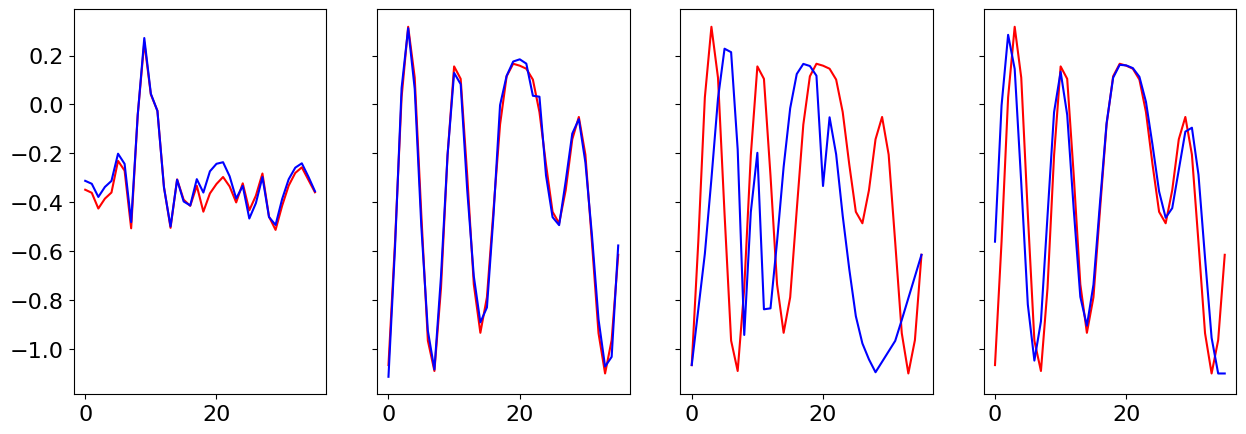

In [155]:
fig, ax =  plt.subplots(1, 4, figsize=(15, 5), sharey=True)

ax[0].plot(x_train[0, :, 0], color="red")
ax[0].plot(aug.magnitude_warp(x_train, sigma=0.1, knot=10)[0, :, 0], color="blue")

ax[1].plot(x_train[2, :, 0], color="red")
ax[1].plot(aug.jitter(x_train, sigma=0.05)[2, :, 0], color="blue")

ax[2].plot(x_train[2, :, 0], color="red")
ax[2].plot(aug.time_warp(x_train)[2, :, 0], color="blue")

ax[3].plot(x_train[2, :, 0], color="red")
ax[3].plot(aug.window_slice(x_train)[2, :, 0], color="blue")

plt.show()

In [156]:
x_train = np.append(x_train, aug.jitter(x_train, sigma=0.005)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)
x_train = np.append(x_train, aug.magnitude_warp(x_train, sigma=0.1, knot=10)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)
x_train = np.append(x_train, aug.time_warp(x_train)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)
x_train = np.append(x_train, aug.window_slice(x_train)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)

indexes = np.random.choice(x_train.shape[0], x_train.shape[0])
x_train = x_train[indexes]
y_train = y_train[indexes]

In [157]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# NOW USE THE GENERATED TIME SERIES TO TRAIN OUR MODELS

Vanilla Attempts:
-CNN1D :

In [158]:
def ReluBatch(input_layer):
  relu  = tfkl.ReLU()(input_layer)
  bn    = tfkl.BatchNormalization()(relu)
  return bn

### CNN-1D Basic model

In [159]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200


def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    out = ReluBatch(lstm)
    dropout = tfkl.Dropout(.3, seed=seed)(out)

    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    out = ReluBatch(lstm)
    dropout = tfkl.Dropout(.3, seed=seed)(out)

    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)
    lstm = tfkl.LSTM(128)(dropout)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)
    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor

    # Classifier
    classifier = tfkl.Dense(512, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [160]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_39 (LSTM)              (None, 36, 32)            4992      
                                                                 
 dropout_33 (Dropout)        (None, 36, 32)            0         
                                                                 
 lstm_40 (LSTM)              (None, 36, 32)            8320      
                                                                 
 re_lu_14 (ReLU)             (None, 36, 32)            0         
                                                                 
 batch_normalization_14 (Bat  (None, 36, 32)           128       
 chNormalization)                                                
                                                             

In [166]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
118/118 [==============================] - 13s 106ms/step - loss: 0.0412 - accuracy: 0.9903 - val_loss: 1.9450 - val_accuracy: 0.7179 - lr: 1.0000e-05
Epoch 2/200
118/118 [==============================] - 10s 88ms/step - loss: 0.0381 - accuracy: 0.9911 - val_loss: 1.9458 - val_accuracy: 0.7179 - lr: 1.0000e-05
Epoch 3/200
118/118 [==============================] - 10s 88ms/step - loss: 0.0380 - accuracy: 0.9910 - val_loss: 1.9443 - val_accuracy: 0.7179 - lr: 1.0000e-05
Epoch 4/200
118/118 [==============================] - 11s 93ms/step - loss: 0.0344 - accuracy: 0.9917 - val_loss: 1.9301 - val_accuracy: 0.7179 - lr: 1.0000e-05
Epoch 5/200
118/118 [==============================] - 11s 90ms/step - loss: 0.0356 - accuracy: 0.9913 - val_loss: 1.9170 - val_accuracy: 0.7128 - lr: 1.0000e-05
Epoch 6/200
118/118 [==============================] - 11s 90ms/step - loss: 0.0355 - accuracy: 0.9913 - val_loss: 1.9284 - val_accuracy: 0.7128 - lr: 1.0000e-05
Epoch 7/200
118/118 [======

In [170]:
model.save('Preprocess-CNN')

INFO:tensorflow:Assets written to: Preprocess-CNN/assets


INFO:tensorflow:Assets written to: Preprocess-CNN/assets


In [167]:
# Predict the test set with the 1DCNN
predictions = model.predict(x_test)
predictions.shape

16/16 [==============================] - 1s 43ms/step


(486, 12)

Accuracy: 0.6564
Precision: 0.5553
Recall: 0.52
F1: 0.5324


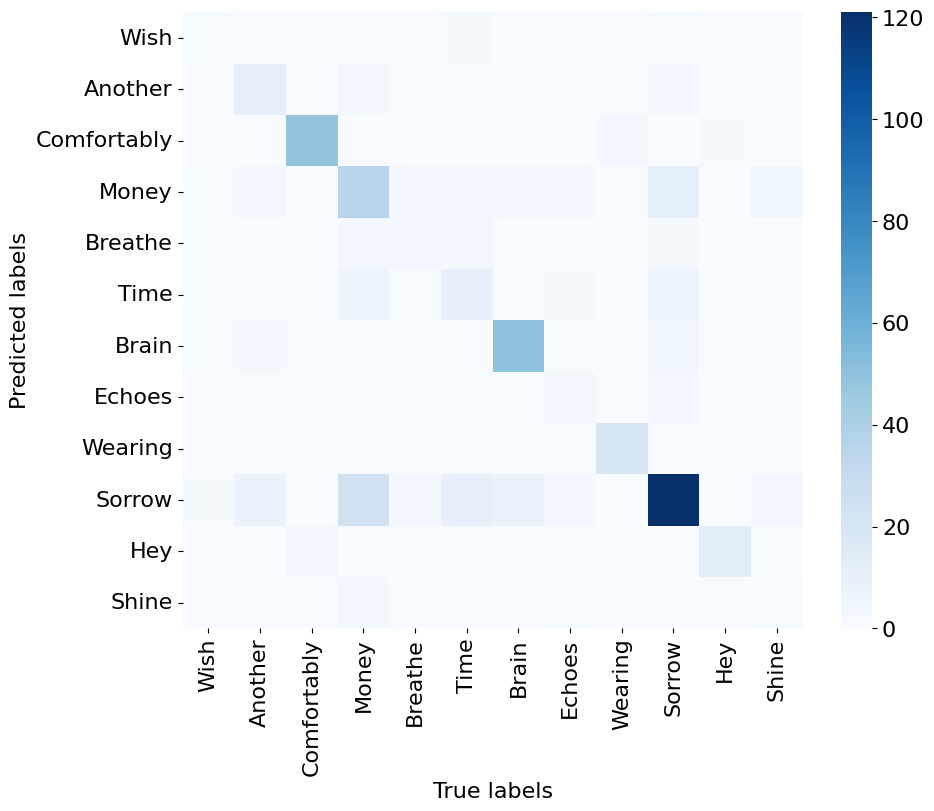

In [168]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Vanilla LSTM

In [47]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200
input_shape, classes


def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(16, return_sequences=True)(input_layer)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(16, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(128)(dropout)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE

    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(512, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [48]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 36, 16)            1472      
                                                                 
 lstm_7 (LSTM)               (None, 36, 16)            2112      
                                                                 
 lstm_8 (LSTM)               (None, 36, 32)            6272      
                                                                 
 lstm_9 (LSTM)               (None, 36, 32)            8320      
                                                                 
 lstm_10 (LSTM)              (None, 36, 64)            24832     
                                                                 
 lstm_11 (LSTM)              (None, 36, 64)            33024 

In [49]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-14 19:32:39.532570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:39.971656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:40.048782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:40.128103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:40.204911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:40.284356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:40.358049: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 2.0982 - accuracy: 0.3296

2022-12-14 19:32:47.210457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:47.394960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:47.490141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:47.579392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:47.661914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:47.747524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:32:47.831738: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - 14s 167ms/step - loss: 2.0982 - accuracy: 0.3296 - val_loss: 1.9513 - val_accuracy: 0.3253 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 4s 94ms/step - loss: 1.7308 - accuracy: 0.4127 - val_loss: 1.6828 - val_accuracy: 0.3818 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 4s 97ms/step - loss: 1.6198 - accuracy: 0.4556 - val_loss: 1.6007 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 4s 97ms/step - loss: 1.5464 - accuracy: 0.4788 - val_loss: 1.5592 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 4s 93ms/step - loss: 1.5053 - accuracy: 0.5008 - val_loss: 1.4887 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 4s 96ms/step - loss: 1.4569 - accuracy: 0.5185 - val_loss: 1.4382 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 4s 95ms/step - loss: 1.4125

In [6]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'model' is not defined

### Bidirectional-LSTM

In [300]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    dropout = tfkl.Dropout(.2, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [301]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 36, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                             

In [302]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 19:38:52.800049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.302474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.423981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.615116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.631122: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 2.0191 - accuracy: 0.3544

2022-12-12 19:39:00.703929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.834830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.843495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.004557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.013282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.181292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.191254: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - 12s 172ms/step - loss: 2.0191 - accuracy: 0.3544 - val_loss: 1.6861 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 4s 89ms/step - loss: 1.6565 - accuracy: 0.4285 - val_loss: 1.5348 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 4s 87ms/step - loss: 1.5245 - accuracy: 0.4705 - val_loss: 1.4584 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 4s 99ms/step - loss: 1.4548 - accuracy: 0.4882 - val_loss: 1.4107 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 4s 88ms/step - loss: 1.3972 - accuracy: 0.4987 - val_loss: 1.4095 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3546 - accuracy: 0.5158 - val_loss: 1.3105 - val_accuracy: 0.5599 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3160

In [303]:
#model.save('Preprocessing-BiLSTM')

16/16 [==============================] - 1s 47ms/step
Accuracy: 0.5134
Precision: 0.5267
Recall: 0.4317
F1: 0.4572


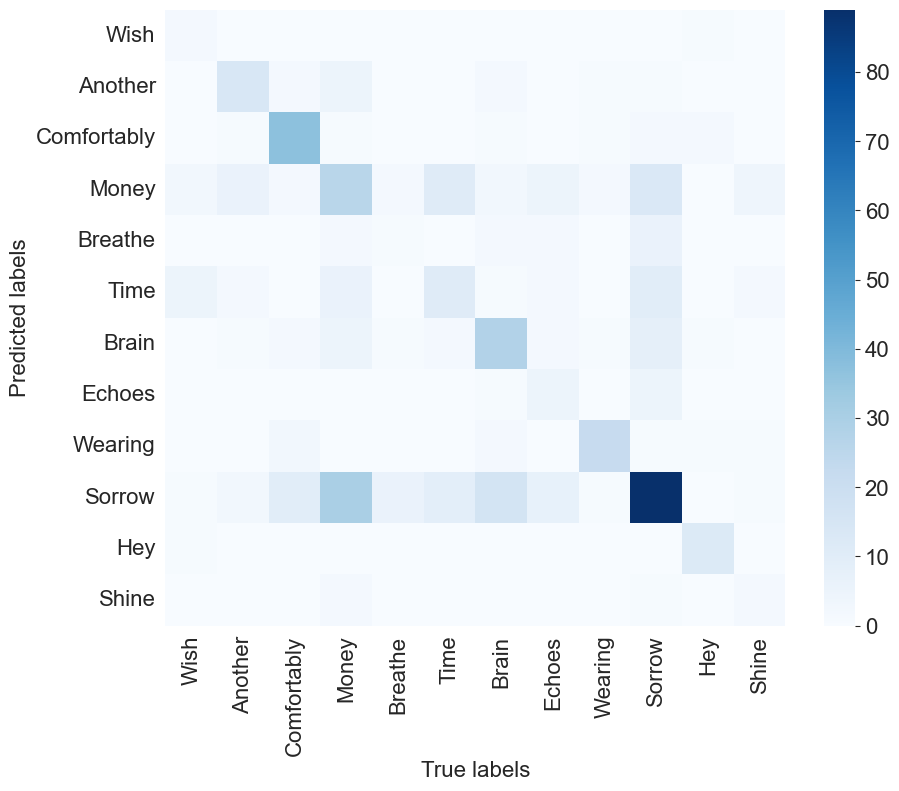

In [305]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### HYBRID CNN-LSTM


In [66]:
def build_Hybrid(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256, 7, padding='same', activation='relu')(input_layer)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    lstm = tfkl.LSTM(128)(lstm)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.2, seed=seed)(lstm)

    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model